# Imports 

In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
import os
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import r_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import matthews_corrcoef, roc_auc_score, balanced_accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc, confusion_matrix
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from src.functions import NestedCrossVal, Classifier 
classifier=Classifier()
ncv=NestedCrossVal()

# Load data

In [5]:
path_to_data="/home/user_stel/Assignment-2/data/breast_cancer.csv"
data_df=classifier.load_data(path_to_data)

#print(data_df.head()) #it should display a 512x32 dataframe

# Preprocess data

In [6]:
data_new_df=classifier.preprocess_data(data_df, columns_to_drop=None)

# Feature Selection

In [7]:
X, y=classifier.separate_features_target(data_new_df, target='diagnosis', columns_to_remove=None)
#print(X)
#print(y)

In [8]:
selected_features, correlations=classifier.select_features(X, y, threshold=0.5)
print(selected_features)

# Creates a new dataset that contains only the selected features 
X_selected=X[selected_features]
#print(X_selected)

selected_feature_names = X_selected.columns.tolist()
target = 'diagnosis'
data_selected_df = data_new_df[selected_feature_names + [target]]
#print(data_selected_df) # the way this new dataframe is built the diagnosis column is last

The selected features of 31 were: 15
['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']


### Model initialization 

In [9]:
model=LogisticRegression(penalty='elasticnet', solver='saga', random_state=0, max_iter=10000)
logreg_param_grid=[{
      'penalty': ['elasticnet'],
      'C':       [0.01, 0.1, 1, 10],
      'l1_ratio':[0.0, 0.25, 0.5, 0.75, 1.0],
      'solver': ['saga'],
      'max_iter': [10000]   # saga can be slower; give it more room
    }
    ]

In [10]:
logreg_param_combinations=ncv.generate_param_combinations(param_grid=logreg_param_grid)
logreg_combo_df_summary = pd.DataFrame.from_dict(logreg_param_combinations, orient='index')
print(logreg_combo_df_summary)

                                                           0   \
__winner__  {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio...   

                                                           1   \
__winner__  {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio...   

                                                           2   \
__winner__  {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio...   

                                                           3   \
__winner__  {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio...   

                                                           4   \
__winner__  {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio...   

                                                           5   \
__winner__  {'penalty': 'elasticnet', 'C': 0.1, 'l1_ratio'...   

                                                           6   \
__winner__  {'penalty': 'elasticnet', 'C': 0.1, 'l1_ratio'...   

                                                           7   \
__winner__  {'pena

# Hyperparameter Tuning using 5-fold Cross Validation

In [11]:
logreg_results=classifier.model_tuning(LogisticRegression, X, y, param_grid=logreg_param_grid, cv=5)

[LogisticRegression] Tested params: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 0.0, 'solver': 'saga', 'max_iter': 10000}
[LogisticRegression] AUC: 0.9655
[LogisticRegression] New best AUC: 0.9655
[LogisticRegression] Best params so far: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 0.0, 'solver': 'saga', 'max_iter': 10000}
[LogisticRegression] Tested params: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 0.25, 'solver': 'saga', 'max_iter': 10000}
[LogisticRegression] AUC: 0.9649
[LogisticRegression] Tested params: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 0.5, 'solver': 'saga', 'max_iter': 10000}
[LogisticRegression] AUC: 0.9638
[LogisticRegression] Tested params: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 0.75, 'solver': 'saga', 'max_iter': 10000}
[LogisticRegression] AUC: 0.9640
[LogisticRegression] Tested params: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 1.0, 'solver': 'saga', 'max_iter': 10000}
[LogisticRegression] AUC: 0.9639
[LogisticRegression] Tes

In [12]:
best_model  = logreg_results['Best Model']
best_params = logreg_results['Best Params']
best_auc    = logreg_results['Best AUC']

# print them
print(f"Best AUC:   {best_auc:.4f}")
print(f"Best Model: {best_model}")
print(f"Best Params: {best_params}")

Best AUC:   0.9658
Best Model: LogisticRegression(C=0.1, l1_ratio=0.25, max_iter=10000, penalty='elasticnet',
                   solver='saga')
Best Params: {'penalty': 'elasticnet', 'C': 0.1, 'l1_ratio': 0.25, 'solver': 'saga', 'max_iter': 10000}


# Training 

In [11]:
classifier.train_final_model(LogisticRegression(C=0.1, l1_ratio=0.25, max_iter=10000, penalty='elasticnet',
                   solver='saga'), X, y, save_path="./winner_model.pkl", scale=True)

Final model trained on all data and saved to ./winner_model.pkl


LogisticRegression(C=0.1, l1_ratio=0.25, max_iter=10000, penalty='elasticnet',
                   solver='saga')

Model: LogisticRegression AUC: 0.9630


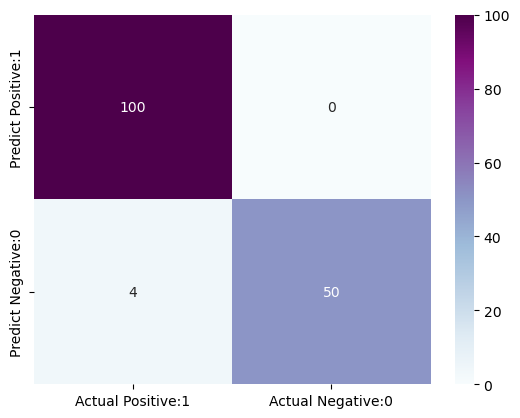

In [23]:
logreg_auc=classifier.train_tuned_model(LogisticRegression(C=0.1, l1_ratio=0.25, max_iter=10000, penalty='elasticnet',
                   solver='saga'), X, y, cmap='BuPu', save_path=None, scale=True)